<div align="center">

# Devoir 3 - 8IAR403<br>
<div align="center">
Etudiant : Maël Garnier (GARM02020500)<br><br>
Le 14 avril 2025<br><br>
</div></div>


In [33]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 1. Préparation des données

## 1.1 Pipeline de transformation

Nous avions déjà réalisé le pipeline de transformation lors du devoir 1. Nous allons donc le réutiliser ici.

Tout le code suivant est une copie condensée du code du devoir 1.

In [34]:
#### Fonction de bornage des données aberrantes (outliers)
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns

    #Calcul de l'écart interquartile
    Q25 = df[cols].quantile(0.25)  #Q1 on définit le premier quartile pour c
    Q75 = df[cols].quantile(0.75)
    IQR = Q75 - Q25

    #Calcul des bornages inférieurs et supérieurs à l'IQR
    SeuilMin = (Q25 - 1.5 * IQR)
    SeuilMax = (Q75 + 1.5 * IQR)

    # Remplacer les outliers à l'extérieur des bornes IQR par les valeurs correspondantes
    nouv_df = df[cols].clip(SeuilMin[cols], SeuilMax[cols], axis=1)
    return nouv_df


def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))


#### Fonction de conversion de caractéristiques au format numérique
def toNum(data: pd.DataFrame):
    data['first_item_prize'] = pd.to_numeric(data['first_item_prize'])
    return data


### Pipeline de traitement des données numériques
num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, validate=False)),
    # Nettoyage par remplacement de valeurs manquantes
    ('imputer', SimpleImputer(strategy="median")),
    # Remplacement des données aberrantes
    ('clamp', FunctionTransformer(bornage, validate=False))
])

### Pipeline de traitement des données catégorielles
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Pipeline de tranformation des données numériques et catégorielles
preparationData = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

### Pipeline complet
full_pipeline = Pipeline([
    ('preparation', preparationData),
    ('standard_scaler', StandardScaler())
])

## 1.2. Traitement des données

Nous allons maintenant traiter les données afin de produire les jeux d'entrainement et de test conformément aux devoirs 1 et 2.

In [35]:
data_client = pd.read_csv(os.path.join("", "Customer.csv"), na_values=['?', 'unknown'])
train_set, test_set = train_test_split(data_client, test_size=0.2, random_state=42)
train_set["revenue"] = train_set["revenue"].replace(np.nan, train_set["revenue"].median())
test_set["revenue"] = test_set["revenue"].replace(np.nan, test_set["revenue"].median())


def binarize_att(data: pd.DataFrame, att_name):
    att_mean = data[att_name].mean()
    data[att_name] = np.where(data[att_name] > att_mean, 1, 0)
    return data


# Transformation de l'attribut revenue en classe binaire pour les ensembles d'entrainement et de test
train_set_bin = binarize_att(train_set.copy(), "revenue")
test_set_bin = binarize_att(test_set.copy(), "revenue")

X_train = train_set_bin.drop(['revenue'], axis=1)
Y_train = train_set_bin['revenue']
X_test = test_set_bin.drop(['revenue'], axis=1)
Y_test = test_set_bin['revenue']

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

X_train, Y_train = resample(X_train, Y_train, n_samples=8000, random_state=42, stratify=Y_train)


# 2. Entraînement d’un classeur binaire et multi-classes pour la vente en ligne avec scikit-learn

## 2.1 Classeur binaire

### 2.1.1 Entraînement du modèle

Nous pouvons maintenant entrainer le modèle sur les données d'entrainement.

Conformément au sujet du DM, le modèle est un MLPClassifier correspondant à un Perceptron multicouche. On garde les paramètre par défaut, à savoir :
hidden_layer_sizes=(100,),
activation='relu',
solver='adam',
learning_rate='constant'

On augmente le nombre maximal d'itération pour ne pas avoir de problème au travers des différentes étapes de test et d'évaluation.

In [36]:
pmc_customer = MLPClassifier(max_iter=10000)
pmc_customer.fit(X_train, Y_train)

MLPClassifier(max_iter=10000)

### 2.1.2 Mesure des métriques de précision
Maintenant que le modèle est créé et entrainé, nous pouvons calculer la precision, le rappel et la F1-mesure avec de la validation croisée.

In [37]:
precision_scorer = make_scorer(precision_score, average="weighted")
recall_scorer = make_scorer(recall_score, average="weighted")
f1_scorer = make_scorer(f1_score, average="weighted")

# Validation croisée avec précision
precision_scores = cross_val_score(pmc_customer, X_train, Y_train, scoring=precision_scorer, cv=3)
print(f"Précision : {precision_scores.mean()} ± {precision_scores.std()}")

# Validation croisée avec rappel
recall_scores = cross_val_score(pmc_customer, X_train, Y_train, scoring=recall_scorer, cv=3)
print(f"Rappel : {recall_scores.mean()} ± {recall_scores.std()}")

# Validation croisée avec F1-mesure
f1_scores = cross_val_score(pmc_customer, X_train, Y_train, scoring=f1_scorer, cv=3)
print(f"F1-mesure : {f1_scores.mean()} ± {f1_scores.std()}")

res_dict = {
    "precision": float(precision_scores.mean()),
    "recall": float(recall_scores.mean()),
    "f1": float(f1_scores.mean()),
}

Précision : 0.8883856847498582 ± 0.0027764717992419543
Rappel : 0.8900000590698856 ± 0.000453191583260186
F1-mesure : 0.8871060253623583 ± 0.002256811454999251


### 2.1.3 Etude de la courbe d'apprentissage

Nous allons maintenant tracer la courbe d'aprentissage et comparer avec le jeu d'entrainement et le jeu de test.

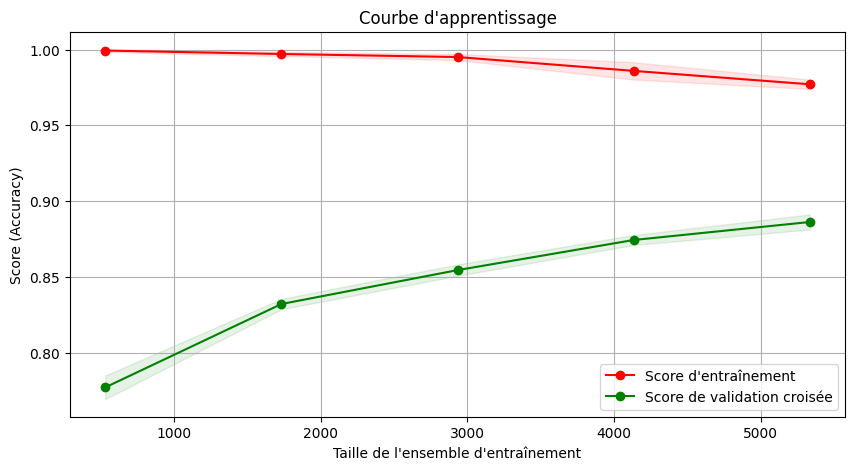

In [38]:
def plot_learning_curve(estimator, x, y):
    _, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.set_title("Courbe d'apprentissage")
    axes.set_xlabel("Taille de l'ensemble d'entraînement")
    axes.set_ylabel("Score (Accuracy)")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracer les scores d'entraînement
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Score d'entraînement")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")

    # Tracer les scores de validation croisée
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Score de validation croisée")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")

    axes.grid()
    axes.legend(loc="best")
    return plt


graph = plot_learning_curve(pmc_customer, X_train, Y_train)
graph.show()

Nous pouvons voir que cette première courbe d'apprentissage montre déjà de bon résultat : le score accuracy est relativement haut, signifiant qu'il n'y a pas de sous-apprentissage. La courbe de validation croisée ainsi que la courbe du score d'entrainement converge, signifiant qu'il n'y a pas de sur-apprentissage.

### 2.1.4 Optimisation des hyperparamètres

In [ ]:
# Définir la grille des hyperparamètres à explorer
param_distributions = {
    'hidden_layer_sizes': [
        i for i in range(10, 101) if i % 5 == 0
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'max_iter': [10000],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    # 'learning_rate_init': uniform(0.0001, 0.1)
}

# Créer le modèle PMC
pmc = MLPClassifier(random_state=42)

# Configurer la recherche aléatoire
random_search = RandomizedSearchCV(pmc, param_distributions, n_iter=10, cv=3, scoring='accuracy', random_state=42,
                                   n_jobs=-1)

# Effectuer la recherche aléatoire
random_search.fit(X_train, Y_train)

# Afficher les meilleurs hyperparamètres et le meilleur score
print("Meilleurs hyperparamètres trouvés :", random_search.best_params_)
print("Meilleure exactitude (validation croisée) :", random_search.best_score_)

# Le meilleur modèle trouvé
best_pmc_customer = random_search.best_estimator_

### 2.1.5 Test du nouveau model

Maintenant que nous avons trouvé les meilleurs hyperparamètres, nous allons mesurer les performances du nouveau modèle.

In [48]:
precision_scorer = make_scorer(precision_score, average="weighted", zero_division=0)
recall_scorer = make_scorer(recall_score, average="weighted", zero_division=0)
f1_scorer = make_scorer(f1_score, average="weighted", zero_division=0)

# Validation croisée avec précision
precision_scores = cross_val_score(best_pmc_customer, X_train, Y_train, scoring=precision_scorer, cv=3)
print(f"Précision : {precision_scores.mean()} ± {precision_scores.std()}")

# Validation croisée avec rappel
recall_scores = cross_val_score(best_pmc_customer, X_train, Y_train, scoring=recall_scorer, cv=3)
print(f"Rappel : {recall_scores.mean()} ± {recall_scores.std()}")

# Validation croisée avec F1-mesure
f1_scores = cross_val_score(best_pmc_customer, X_train, Y_train, scoring=f1_scorer, cv=3)
print(f"F1-mesure : {f1_scores.mean()} ± {f1_scores.std()}")

best_res_dict = {
    "precision": float(precision_scores.mean()),
    "recall": float(recall_scores.mean()),
    "f1": float(f1_scores.mean()),
}

C:\Users\maelg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Précision : 0.89846170399814 ± 0.0012448062158327154


C:\Users\maelg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Rappel : 0.8984997936773281 ± 0.0012542305258705765


C:\Users\maelg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


F1-mesure : 0.8984762786901509 ± 0.0012482030718447622


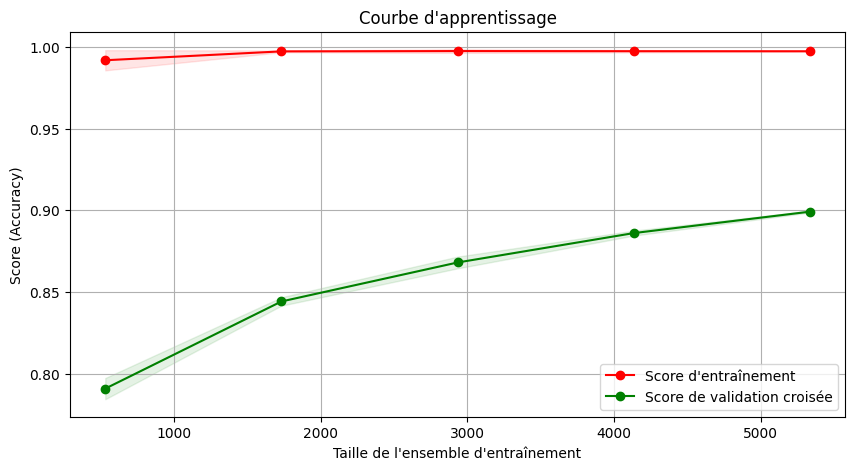

In [49]:
graph = plot_learning_curve(best_pmc_customer, X_train, Y_train)
graph.show()

Nous remarquons que la courbe d'apprentissage présente des valeurs légèrement plus élevées. Aussi, la courbe du score d'entrainement n'est jamais décroissante, ce qui est bon signe. La courbe du score de validation croisée converge toujours vers celle du score d'entrainement.

### 2.1.6 Comparaison des résulats

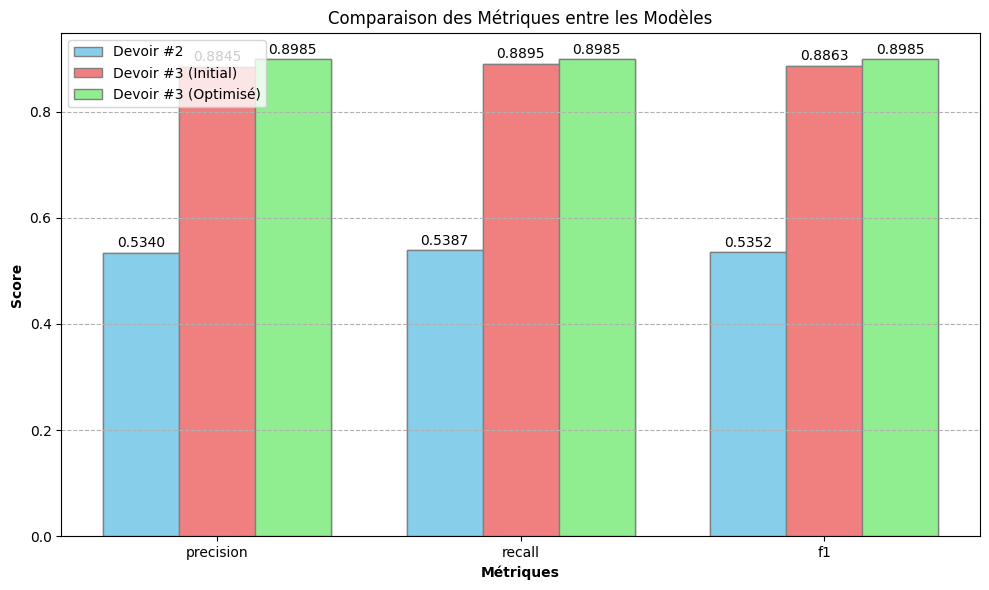

In [50]:
res_dict_d2 = {
    "precision": 0.5340386246474341,
    "recall": 0.5387497042989656,
    "f1": 0.5352227803818687,
}

# Les noms des modèles/devoirs
model_names = ['Devoir #2', 'Devoir #3 (Initial)', 'Devoir #3 (Optimisé)']

# Les métriques à comparer
metrics = ['precision', 'recall', 'f1']

# Extraction des valeurs pour chaque modèle
values_d2 = [res_dict_d2[metric.lower()] for metric in metrics]
values_res = [res_dict[metric.lower()] for metric in metrics]
values_best = [best_res_dict[metric.lower()] for metric in metrics]

# Largeur des barres
bar_width = 0.25

# Positions des barres pour chaque groupe
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Créer le graphique à barres groupées
plt.figure(figsize=(10, 6))
plt.bar(r1, values_d2, color='skyblue', width=bar_width, edgecolor='grey', label=model_names[0])
plt.bar(r2, values_res, color='lightcoral', width=bar_width, edgecolor='grey', label=model_names[1])
plt.bar(r3, values_best, color='lightgreen', width=bar_width, edgecolor='grey', label=model_names[2])

# Ajouter des étiquettes sur l'axe des x (les noms des métriques)
plt.xlabel('Métriques', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)

# Ajouter un titre et une légende
plt.ylabel('Score', fontweight='bold')
plt.title('Comparaison des Métriques entre les Modèles')
plt.legend()

# Ajouter une grille pour faciliter la lecture
plt.grid(axis='y', linestyle='--')
plt.ylim(0, max(max(values_d2), max(values_res), max(values_best)) + 0.05)  # Ajuster la limite y


# Ajouter les valeurs au-dessus des barres (facultatif)
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., height + 0.005, f'{height:.4f}',
                 ha='center', va='bottom')


add_labels(plt.bar(r1, values_d2, color='skyblue', width=bar_width, edgecolor='grey'))
add_labels(plt.bar(r2, values_res, color='lightcoral', width=bar_width, edgecolor='grey'))
add_labels(plt.bar(r3, values_best, color='lightgreen', width=bar_width, edgecolor='grey'))

# Afficher le graphique
plt.tight_layout()
plt.show()

La première chose que nous pouvons remarquer est que le modèle, que ses hyperparamètres soient ajustés ou non, surpasse largement le modèle Decision Tree du devoir 2. Nous pouvons également remarquer que le modèle optimisé est légèrement meilleur que le modèle initial, signifiant que l'optimisation des hyperparamètres à portée ses fruits.

## 2.2 Classeur multi-classes

### 2.2.1 Entraînement du modèle


In [21]:
def categorize_att(data: pd.DataFrame, att_name):
    att_mean = data[att_name].mean()
    att_std = data[att_name].std()

    bins = [data[att_name].min() - 1,  # Pour inclure toutes les valeurs basses
            att_mean - att_std,
            att_mean + att_std,
            data[att_name].max() + 1]  # Pour inclure toutes les valeurs élevées
    labels = [0, 1, 2]  # 0: Bas, 1: Moyen, 2: Élevé

    data[att_name + '_category'] = pd.cut(data[att_name], bins=bins, labels=labels, right=False)
    return data

train_set_multi = categorize_att(train_set.copy(), "revenue")
test_set_multi = categorize_att(test_set.copy(), "revenue")
Y_train_mult = train_set_multi['revenue_category'].astype(int)
Y_test_mult = test_set_multi['revenue_category'].astype(int)
X_train_mult = full_pipeline.fit_transform(train_set_multi.drop(['revenue', 'revenue_category'], axis=1))
X_test_mult = full_pipeline.fit_transform(test_set_multi.drop(['revenue', 'revenue_category'], axis=1))
X_train_mult, Y_train_mult = resample(X_train_mult, Y_train_mult,
                            n_samples=8000, random_state=42,
                            stratify=Y_train)
pmc_customer_mult = MLPClassifier(max_iter=10000)
pmc_customer_mult.fit(X_train_mult, Y_train_mult)

MLPClassifier(max_iter=10000)


### 2.2.2 Evaluation du classeur multiclass

Maintenant que nous avons créé nos classe et entrainé de nouveaux models, nous pouvons l'évaluer

In [22]:
precision_scorer = make_scorer(precision_score, average="weighted")
recall_scorer = make_scorer(recall_score, average="weighted")
f1_scorer = make_scorer(f1_score, average="weighted")

# Validation croisée avec précision
precision_scores = cross_val_score(pmc_customer_mult, X_train_mult, Y_train_mult, scoring=precision_scorer, cv=3)
print(f"Précision : {precision_scores.mean()} ± {precision_scores.std()}")

# Validation croisée avec rappel
recall_scores = cross_val_score(pmc_customer_mult, X_train_mult, Y_train_mult, scoring=recall_scorer, cv=3)
print(f"Rappel : {recall_scores.mean()} ± {recall_scores.std()}")

# Validation croisée avec F1-mesure
f1_scores = cross_val_score(pmc_customer_mult, X_train_mult, Y_train_mult, scoring=f1_scorer, cv=3)
print(f"F1-mesure : {f1_scores.mean()} ± {f1_scores.std()}")

res_dict_mult = {
    "precision": float(precision_scores.mean()),
    "recall": float(recall_scores.mean()),
    "f1": float(f1_scores.mean()),
}

Précision : 0.8808358058396463 ± 0.005633753353821373
Rappel : 0.8832489805991056 ± 0.005768633591959059
F1-mesure : 0.8734822145924106 ± 0.00423082748376955


Nous pouvons observer que les résultats sont légèrement moins bon que pour le classeur binaire, comme on peut s'y attendre. Regardons maintenant la courbe d'apprentissage.

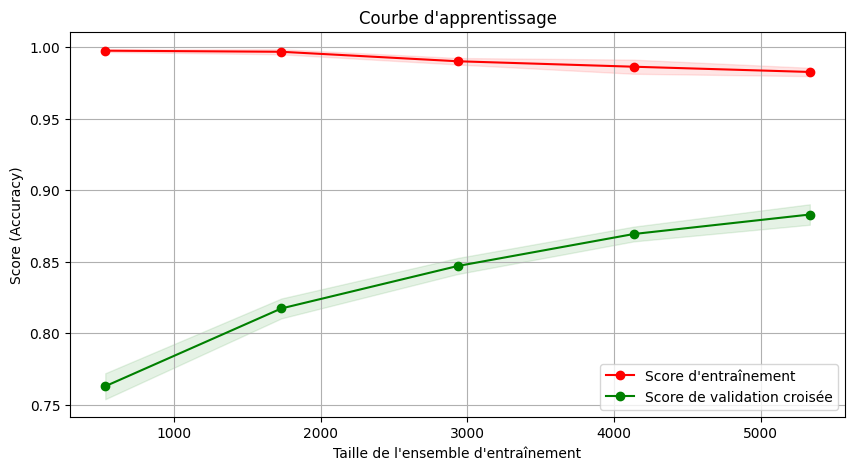

In [25]:
graph = plot_learning_curve(pmc_customer_mult, X_train_mult, Y_train_mult)
graph.show()

Nous pouvons remarquer que la courbe d'apprentissage est toujours similaire à ce qu'on a déjà eu. Les valeurs sont simplement légèrement inférieur au modèle binaire.

### 2.2.3 Optimisation des hyperparamètres

In [27]:
pmc = MLPClassifier(random_state=42)
random_search = RandomizedSearchCV(pmc, param_distributions, n_iter=10, cv=3, scoring='accuracy', random_state=42,
                                   n_jobs=-1)

# Effectuer la recherche aléatoire
random_search.fit(X_train_mult, Y_train_mult)

# Afficher les meilleurs hyperparamètres et le meilleur score
print("Meilleurs hyperparamètres trouvés :", random_search.best_params_)
print("Meilleure exactitude (validation croisée) :", random_search.best_score_)

# Le meilleur modèle trouvé
best_pmc_customer_mult = random_search.best_estimator_

Meilleurs hyperparamètres trouvés : {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': 95, 'activation': 'logistic'}
Meilleure exactitude (validation croisée) : 0.894623730923357


### 2.2.4 Evaluation du nouveau modèle

Maintenant que nous avons un modèle optimisé pour le multiclass, nous allons tester avec les métriques de précision et observer la courbe d'apprentissage.

In [30]:
precision_scorer = make_scorer(precision_score, average="weighted", zero_division=0)
recall_scorer = make_scorer(recall_score, average="weighted", zero_division=0)
f1_scorer = make_scorer(f1_score, average="weighted", zero_division=0)

# Validation croisée avec précision
precision_scores = cross_val_score(best_pmc_customer_mult, X_train_mult, Y_train_mult, scoring=precision_scorer, cv=3)
print(f"Précision : {precision_scores.mean()} ± {precision_scores.std()}")

# Validation croisée avec rappel
recall_scores = cross_val_score(best_pmc_customer_mult, X_train_mult, Y_train_mult, scoring=recall_scorer, cv=3)
print(f"Rappel : {recall_scores.mean()} ± {recall_scores.std()}")

# Validation croisée avec F1-mesure
f1_scores = cross_val_score(best_pmc_customer_mult, X_train_mult, Y_train_mult, scoring=f1_scorer, cv=3)
print(f"F1-mesure : {f1_scores.mean()} ± {f1_scores.std()}")

best_res_dict_mult = {
    "precision": float(precision_scores.mean()),
    "recall": float(recall_scores.mean()),
    "f1": float(f1_scores.mean()),
}

Précision : 0.8929455913997023 ± 0.007488999417475252
Rappel : 0.894623730923357 ± 0.007865820416524293
F1-mesure : 0.8930045466922492 ± 0.0071563812625426645


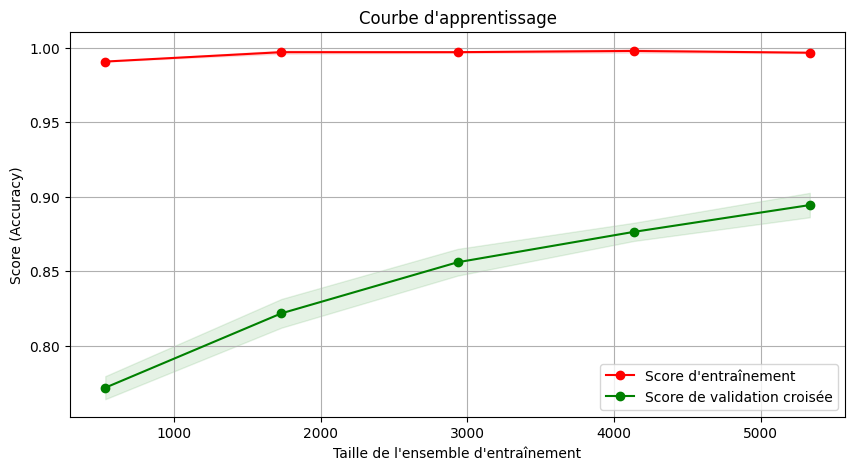

In [29]:
graph = plot_learning_curve(best_pmc_customer_mult, X_train_mult, Y_train_mult)
graph.show()

Nous pouvons remarquer que la courbe d'apprentissage est très similaire à celle trouvée par le modèle binaire optimisé, avec des résultats légèrement moins bon.
La courbe d'apprentissage ne présente aucun signe de sur-apprentissage ou sous-apprentissage.

### 2.2.5 Comparaison des résultats



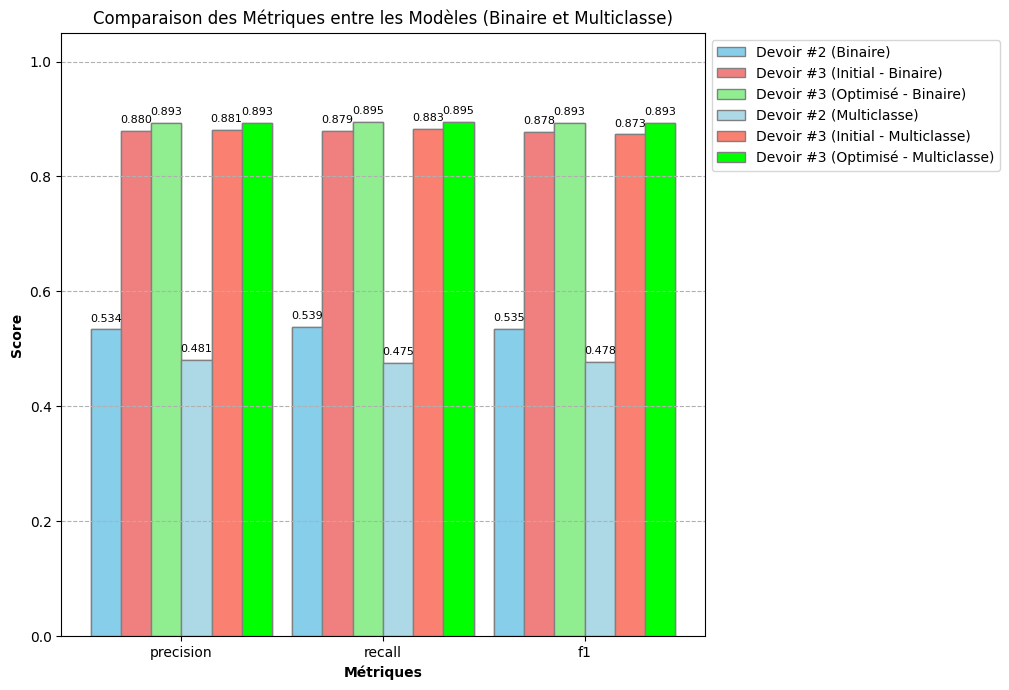

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Vos dictionnaires de résultats binaires
res_dict_d2 = {
    "precision": 0.5340386246474341,
    "recall": 0.5387497042989656,
    "f1": 0.5352227803818687,
}

res_dict_d2_mult = {
    "precision": 0.48111648379074884,
    "recall": 0.4753740459861872,
    "f1": 0.4780598611296307,
}

# Les noms des modèles/devoirs
model_names = ['Devoir #2 (Binaire)', 'Devoir #3 (Initial - Binaire)', 'Devoir #3 (Optimisé - Binaire)',
               'Devoir #2 (Multiclasse)', 'Devoir #3 (Initial - Multiclasse)', 'Devoir #3 (Optimisé - Multiclasse)']

# Les métriques à comparer
metrics = ['precision', 'recall', 'f1']
n_metrics = len(metrics)
n_models = len(model_names)

# Largeur des barres
bar_width = 0.15

# Positions des groupes de barres
index = np.arange(n_metrics)

# Valeurs pour chaque modèle et chaque métrique
values = {
    'Devoir #2 (Binaire)': [res_dict_d2['precision'], res_dict_d2['recall'], res_dict_d2['f1']],
    'Devoir #3 (Initial - Binaire)': [res_dict['precision'], res_dict['recall'], res_dict['f1']],
    'Devoir #3 (Optimisé - Binaire)': [best_res_dict['precision'], best_res_dict['recall'], best_res_dict['f1']],
    'Devoir #2 (Multiclasse)': [res_dict_d2_mult['precision'], res_dict_d2_mult['recall'], res_dict_d2_mult['f1']],
    'Devoir #3 (Initial - Multiclasse)': [res_dict_mult['precision'], res_dict_mult['recall'], res_dict_mult['f1']],
    'Devoir #3 (Optimisé - Multiclasse)': [best_res_dict_mult['precision'], best_res_dict_mult['recall'], best_res_dict_mult['f1']],
}

# Couleurs pour les modèles
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'salmon', 'lime']

# Créer le graphique à barres groupées
plt.figure(figsize=(12, 7))

for i, model_name in enumerate(model_names):
    positions = index + i * bar_width
    plt.bar(positions, values[model_name], bar_width, label=model_name, color=colors[i], edgecolor='grey')

# Ajouter des étiquettes sur l'axe des x (les noms des métriques)
plt.xlabel('Métriques', fontweight='bold')
plt.xticks(index + (n_models / 2 - 0.5) * bar_width, metrics)

# Ajouter un titre et une légende
plt.ylabel('Score', fontweight='bold')
plt.title('Comparaison des Métriques entre les Modèles (Binaire et Multiclasse)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Ajouter une grille pour faciliter la lecture
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1.05)  # Ajuster la limite y

# Ajouter les valeurs au-dessus des barres (facultatif)
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., height + 0.01, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=8)

# Ajouter les labels pour chaque barre
for i, model_name in enumerate(model_names):
    positions = index + i * bar_width
    rects = plt.bar(positions, values[model_name], bar_width, color=colors[i], edgecolor='grey')
    add_labels(rects)

# Afficher le graphique
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajuster pour faire de la place pour la légende
plt.show()